# Protocol Data Blob 

Goal: load protocol data blob in from matlab & unpack

Protocol Data structure for DMS:

| variable             | values          | key                                                 |
|----------------------|-----------------|-----------------------------------------------------|
| `hit_history`        | [0, 1, NaN]     | [error, hit, violation]                             |
| `temp_error_history` | [0, 1, NaN]     | [no terror, terror, violation]                      |
| `side_history`       | [l, r]          | [left, right]                                       |
| `result_history`     | [1, 2, 3, 4, 5] | [hit, error, violation, terror, crash]              |
| `sa`                 | float           | value of sa in Hz                                   |
| `sb`                 | float           | value of sb in Hz                                   |
| `dms_type`           | [0, 1]          | [nonmatch, match]                                   |
| `delay`              | float           | duration of delay between sa/sb in s                |
| `fixation`           | float           | duration of pre --> go (fixation required or not)   |
| `timeouts`           | float           | duration of timeout in s                            |
| `helper`             | [0, 1]          | if trial was in helper block (not in use currently) |
| `stage`              | float           | stage number                                        |


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import datajoint as dj
import pandas as pd
import os
import seaborn as sns
import pandas as pd
from pathlib import Path
from datetime import date 

from io_utils import *

# settings
%reload_ext autoreload
%autoreload 2
dj.blob.use_32bit_dims = True # necessary for pd.blob read
 

### Single Session

In [52]:
# grab protocol data from a session
bdata = dj.create_virtual_module('new_acquisition', 'bdatatest')
session_key = {'sessid': 879663}
session_data = (bdata.Sessions & session_key).fetch('protocol_data', as_dict=True)

In [17]:
protocol_dict = convert_to_dict(session_data)
for key,value in protocol_dict[0].items():

    print(f"{key} length:{len(value)}")

hits length:67
temperror length:67
sides length:67
result length:59
sa length:67
sb length:68
dms_type length:67
delay length:67
fixation length:67
timeouts length:67
helper length:67
stage length:67


In [53]:
animal_id = 'R501'
sessid =  session_key['sessid']
date = "2022-07-19"
protocol_dict = convert_to_dict(session_data)
# protocol_df = make_protocol_df(protocol_dict, animal_id, [date], [sessid])

# protocol_df.head()

In [56]:
prepare_dict_for_df(protocol_dict[0])

### Multi Session

In [12]:
df = fetch_latest_protocol_data()

fetched 30 sessions for R500
8 crash trials found for R501 on 879663
9 crash trials found for R501 on 880204
fetched 32 sessions for R501
9 crash trials found for R502 on 880203
9 crash trials found for R502 on 880488
fetched 33 sessions for R502
2 crash trials found for R503 on 880437
fetched 31 sessions for R503
fetched 33 sessions for R600


In [13]:
df_reread = pd.read_csv(Path(PROTOCOL_DATA_PATH, '220819_protocol_data.csv'), index_col=[0])
df_reread.head()

,trial,animal_id,date,sessid,hits,temperror,sides,result,sa,sb,delay,fixation,timeouts,helper,stage,is_match
0,1,R500,2022-07-19,879474.0,0.0,1.0,l,4,12.0,12.0,0.1,1.1,0.1,0.0,1.0,True
1,2,R500,2022-07-19,879474.0,0.0,1.0,l,4,12.0,12.0,0.1,0.5,0.1,0.0,1.0,True
2,3,R500,2022-07-19,879474.0,1.0,0.0,r,1,12.0,3.0,0.1,0.5,NaN,0.0,1.0,False
3,4,R500,2022-07-19,879474.0,1.0,0.0,r,1,3.0,12.0,0.1,0.5,NaN,0.0,1.0,False
4,5,R500,2022-07-19,879474.0,0.0,1.0,r,4,12.0,3.0,0.1,0.5,0.1,0.0,1.0,False


In [14]:
for _id, animal_df in df.groupby('animal_id'):
    print(_id)
animal_df

R500
R501
R502
R503
R600


,trial,animal_id,date,sessid,hits,temperror,sides,result,sa,sb,delay,fixation,timeouts,helper,stage,is_match
0,1,R600,2022-07-19,879484.0,1,0,l,1,3.0,3.0,0.10,1.10,NaN,0,1,True
1,2,R600,2022-07-19,879484.0,1,0,r,1,12.0,3.0,0.10,0.50,NaN,0,1,False
2,3,R600,2022-07-19,879484.0,1,0,l,1,3.0,3.0,0.10,0.50,NaN,0,1,True
3,4,R600,2022-07-19,879484.0,1,0,l,1,12.0,12.0,0.10,0.50,NaN,0,1,True
4,5,R600,2022-07-19,879484.0,1,0,l,1,12.0,12.0,0.10,0.50,NaN,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,182,R600,2022-08-19,882623.0,0,0,l,2,3.0,3.0,0.05,0.53,0.500,0,4,True
182,183,R600,2022-08-19,882623.0,1,0,r,1,3.0,12.0,0.05,0.53,NaN,0,4,False
183,184,R600,2022-08-19,882623.0,<NA>,<NA>,l,3,3.0,3.0,0.05,0.53,2.550,0,4,True
184,185,R600,2022-08-19,882623.0,<NA>,<NA>,r,3,3.0,12.0,0.05,0.53,2.575,0,4,False


In [15]:
for sa_sb, sa_sb_df in animal_df.groupby(['sa', 'sb']):
    print(sa_sb)

(3.0, 3.0)
(3.0, 12.0)
(12.0, 3.0)
(12.0, 12.0)


sa: 3.0, sb: 3.0
sa: 3.0, sb: 12.0
sa: 12.0, sb: 3.0
sa: 12.0, sb: 12.0


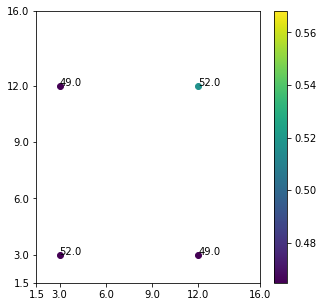

In [32]:
plt.subplots(1,1, figsize=(5,5))
sns.despine
for (sa,sb), sa_sb_df in df.groupby(['sa', 'sb']):
    print(f"sa: {sa}, sb: {sb}")
    performance = sa_sb_df['hits'].mean(skipna=True)
    plt.scatter(sa, sb, c = performance)
    plt.annotate(str(np.round(performance * 100, 0)), (sa,sb))

cbar = plt.colorbar()
y = plt.yticks([1.5, 3, 6, 9, 12, 16])
x = plt.xticks([1.5, 3, 6, 9, 12, 16])

    

TODO: 
* update x axis 
* shift text
* add labels etc
* write plotting fx

In [241]:
animal_df.groupby("trial").mean()

,sessid,hits,temperror,sa,sb,dms_type,delay,fixation,timeouts,helper
trial,,,,,,,,,,
1,880463.923077,0.800000,0.200000,7.500000,8.538462,0.423077,0.134615,1.100000,0.500000,0
2,880463.923077,0.666667,0.166667,7.500000,7.846154,0.423077,0.134615,0.683492,0.471429,0
3,880463.923077,0.578947,0.263158,8.538462,7.153846,0.538462,0.134615,0.684281,0.497333,0
4,880463.923077,0.687500,0.250000,8.192308,7.153846,0.500000,0.134615,0.685085,0.511667,0
5,880463.923077,0.777778,0.166667,7.500000,8.538462,0.653846,0.134615,0.685436,0.515417,0
...,...,...,...,...,...,...,...,...,...,...
118,880566.000000,NaN,NaN,3.000000,12.000000,0.000000,0.100000,0.608960,2.350000,0
119,880566.000000,0.000000,0.000000,3.000000,3.000000,1.000000,0.100000,0.608960,0.500000,0
120,880566.000000,0.000000,0.000000,3.000000,3.000000,1.000000,0.100000,0.610960,0.500000,0


ValueError: cannot reindex from a duplicate axis

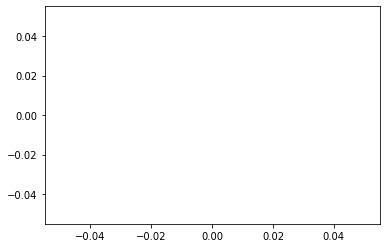

In [242]:
# def my_plot(ax, _df):
    
ax = plt.gca()
sns.lineplot(data=animal_df, x="trial", y='hits',ax=ax)

In [232]:
n_plots = len(xx.animal_id.unique())
plt.subplots(n_plots, 1, figsize=(10,8))

for aid, animal_df in xx.groupby('animal_id'):
    print(aid)
animal_df

R500
R600


,trial,animal_id,date,sessid,hits,temperror,sides,result,sa,sb,dms_type,delay,fixation,timeouts,helper,stage
0,1,R600,2022-07-19,879484.0,1,0,l,1,3.0,3.0,True,0.1,1.100000,NaN,0,1
1,2,R600,2022-07-19,879484.0,1,0,r,1,12.0,3.0,False,0.1,0.500000,NaN,0,1
2,3,R600,2022-07-19,879484.0,1,0,l,1,3.0,3.0,True,0.1,0.500000,NaN,0,1
3,4,R600,2022-07-19,879484.0,1,0,l,1,12.0,12.0,True,0.1,0.500000,NaN,0,1
4,5,R600,2022-07-19,879484.0,1,0,l,1,12.0,12.0,True,0.1,0.500000,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,27,R600,2022-08-13,881572.0,0,1,l,4,3.0,3.0,True,0.1,0.528297,0.820,0,4
27,28,R600,2022-08-13,881572.0,<NA>,<NA>,l,3,12.0,12.0,True,0.1,0.530297,0.850,0,4
28,29,R600,2022-08-13,881572.0,<NA>,<NA>,l,3,3.0,3.0,True,0.1,0.530297,0.875,0,4
29,30,R600,2022-08-13,881572.0,<NA>,<NA>,l,3,3.0,3.0,True,0.1,0.530297,0.900,0,4


### Multi animal query



In [245]:
rats = ['R500', 'R501']
key = [{'ratname' : rat} for rat in rats]

pdata = (bdata.Sessions & key).fetch('protocol_data', as_dict=True)

[2022-08-15 15:57:59,377][WARNING]: MySQL server has gone away. Reconnecting to the server.


In [252]:
pdicts = convert_to_dict(pdata)

AttributeError: 'list' object has no attribute 'keys'

In [255]:
pdicts[0].keys()

dict_keys(['hits', 'temperror', 'sides', 'result', 'sa', 'sb', 'dms_type', 'delay', 'fixation', 'timeouts', 'helper', 'stage'])

#### scraps

In [ ]:
dd = convert_to_dicts(session_data)
dfs = make_protocol_df(dd, ['R500'], ['2022-07-08'], ['su2129'])

updating sb values to be correct


In [157]:
for key in protocol_dict.keys():
    print(f"{key} type:{type(protocol_dict[key][0])} ")

hits type:<class 'numpy.float64'> 
temperror type:<class 'numpy.float64'> 
sides type:<class 'str'> 
result type:<class 'numpy.float64'> 
sa type:<class 'numpy.float64'> 
sb type:<class 'numpy.float64'> 
dms_type type:<class 'numpy.bool_'> 
delay type:<class 'numpy.float64'> 
fixation type:<class 'numpy.float64'> 
timeouts type:<class 'numpy.float64'> 
helper type:<class 'numpy.float64'> 
stage type:<class 'numpy.float64'> 


In [156]:
for key,value in protocol_dict.items():

    `print(f"{key} length:{len(value)}")

hits length:45
temperror length:45
sides length:45
result length:45
sa length:45
sb length:45
dms_type length:45
delay length:45
fixation length:45
timeouts length:45
helper length:45
stage length:45


Additional functions:
* read in pd data for an animal or default group
* or maybe have a load_last lag for the fetch_lastest

VARS:
SAVE_DIR
ANIMAL_IDS

Order:

fetch_latest_protocol_data

convert_to_dict 
* takes blob(s)
* calls mym_blob_to_dict
* returns list of dictonaries

make_protocol_df
* takes dicts, animal id, sessions, dates
* calls correct_sb
* calls clean_protocol_df
* returns list of dataframes

saves out animals data frame as csv

by defualt returns a dictonary with animal name as keys, can also return a list of df instead




In [181]:
as_dict = True
x = 7
[x + 3]  if as_dict is True else x - 3

x

7